In [345]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import ConvLSTM2D
from keras.utils import to_categorical
from keras import backend as K 
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model, model_from_json

from sklearn.metrics import confusion_matrix, auc, roc_curve, roc_auc_score, precision_score, recall_score, f1_score, accuracy_score

In [164]:
activities = {
    1: 'Walking',
    2: 'Walking Upstairs',
    3: 'Walking Downstairs',
    4: 'Sitting',
    5: 'Standing',
    6: 'Laying'
}


In [14]:
# load a single file as a numpy array
def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

In [15]:
# load a list of files into a 3D array of [samples, timesteps, features]
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

In [16]:
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y

In [17]:
def load_dataset(prefix=''):
    # load all train
    X_train, y_train = load_dataset_group('train', prefix)
    print(X_train.shape, y_train.shape)
    # load all test
    X_test, y_test = load_dataset_group('test', prefix)
    print(X_test.shape, y_test.shape)
    # zero-offset class values
    y_train = y_train - 1
    y_test = y_test - 1
    # one hot encode y
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    return X_train, y_train, X_test, y_test

### LSTM Network Model

In [27]:
# fit and evaluate a model
def evaluate_model(X_train, y_train, X_test, y_test):
    verbose, epochs, batch_size = 0, 15, 64
    n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
    K.clear_session()
    model = Sequential()
    model.add(LSTM(100, input_shape=(n_timesteps,n_features)))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_data=(X_test, y_test))
    # evaluate model
    _, accuracy = model.evaluate( X_test, y_test, batch_size=batch_size, verbose=0)
    return history, accuracy

In [19]:
# summarize scores
def summarize_results(scores):
    print(scores)
    m, s = np.mean(scores), np.std(scores)
    print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))

In [28]:
# run the model
def run(repeats=10):
    # load data
    X_train, y_train, X_test, y_test = load_dataset(prefix="data/2012/")
    # repeat experiment
    scores = list()
    results = []
    for r in range(repeats):
        history, score = evaluate_model(X_train, y_train, X_test, y_test)
        score = score * 100.0
        print('>#%d: %.3f' % (r+1, score))
        scores.append(score)
        results.append(pd.DataFrame(history.history, index=history.epoch))
    # summarize results
    summarize_results(scores)
    return results

In [29]:
results=run(repeats=2)

(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)
(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)
>#1: 90.092
>#2: 90.838
[90.09161591529846, 90.83814024925232]
Accuracy: 90.465% (+/-0.373)


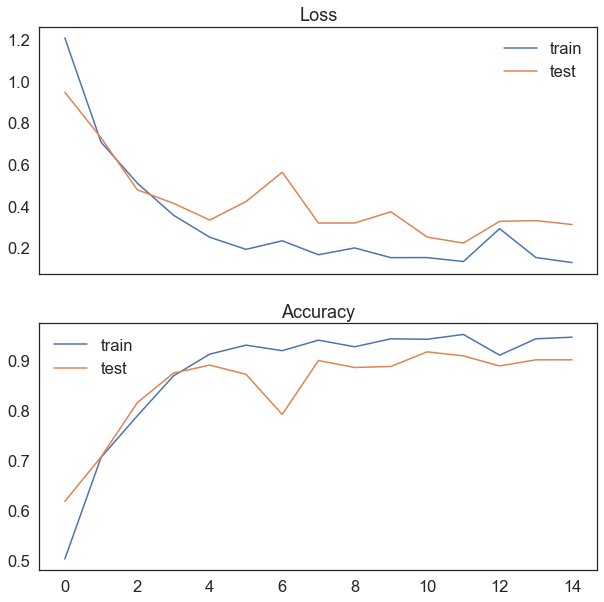

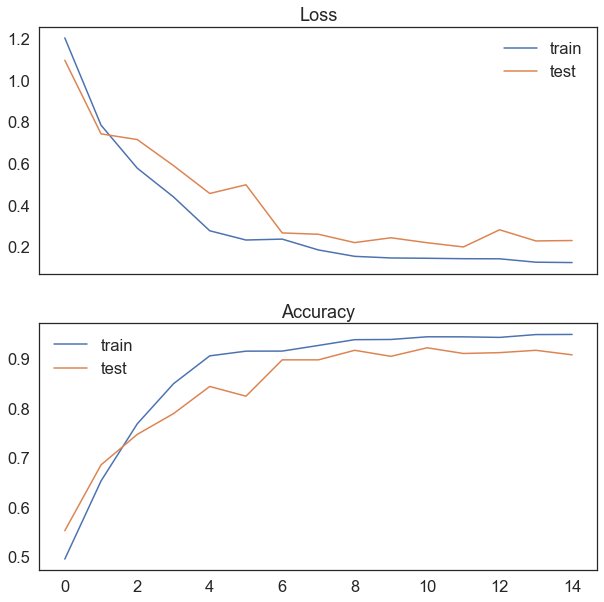

In [56]:
plt.style.use('seaborn-whitegrid')
sns.set(style="white", font_scale = 1.5)
for i in range(len(results)):
    fig, axes = plt.subplots(2,1, figsize=(10,10), sharex=True)
    axes[0].set_title('Loss')
    axes[0].plot(results[i]['loss'], label='train', )
    axes[0].plot(results[i]['val_loss'], label='test')
    axes[0].legend()
    #plot accuracy during training
    axes[1].set_title('Accuracy')
    axes[1].plot(results[i]['accuracy'], label='train')
    axes[1].plot(results[i]['val_accuracy'], label='test')
    axes[1].legend()
    plt.show()

### Base Model

In [ ]:
X_train, y_train, X_test, y_test = load_dataset(prefix="data/2012/")

n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]

In [ ]:
verbose, epochs, batch_size = 1, 15, 64
K.clear_session()
model = Sequential()
model.add(LSTM(128, input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.8))
model.add(Dense(128, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit network
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_split=0.2)
# evaluate model
accuracy = model.evaluate( X_test, y_test, batch_size=batch_size, verbose=verbose)

### CNN-LSTM Network Model

In [103]:
X_train, y_train, X_test, y_test = load_dataset(prefix="data/2012/")
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
# reshape data into time steps of sub-sequences
n_steps, n_length = 4, 32
X_train = X_train.reshape((X_train.shape[0], n_steps, n_length, n_features))
X_test = X_test.reshape((X_test.shape[0], n_steps, n_length, n_features))

(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)
(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)


In [247]:
# early stopping to choose best epoch
es =EarlyStopping(monitor='val_loss', patience=5)
mc = ModelCheckpoint(filepath='models/model.{epoch:02d}-{val_loss:.2f}.h5', monitor='val_loss', mode='min', save_best_only=True)


In [250]:
verbose, epochs, batch_size = 1, 24, 64
# define model
K.clear_session()
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(Conv1D(filters=128, kernel_size=3, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit model
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_split=0.2, callbacks=[es, mc])
# evaluate model
accuracy = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=verbose)

Epoch 1/24
92/92 [==============================] - 3s 28ms/step - loss: 0.9410 - accuracy: 0.5853 - val_loss: 0.6208 - val_accuracy: 0.7736
Epoch 2/24
92/92 [==============================] - 3s 28ms/step - loss: 0.4275 - accuracy: 0.8230 - val_loss: 0.4337 - val_accuracy: 0.8518
Epoch 3/24
92/92 [==============================] - 3s 29ms/step - loss: 0.2666 - accuracy: 0.9012 - val_loss: 0.3368 - val_accuracy: 0.9014
Epoch 4/24
92/92 [==============================] - 3s 30ms/step - loss: 0.1948 - accuracy: 0.9269 - val_loss: 0.3308 - val_accuracy: 0.8987
Epoch 5/24
92/92 [==============================] - 3s 30ms/step - loss: 0.1534 - accuracy: 0.9418 - val_loss: 0.3048 - val_accuracy: 0.8906
Epoch 6/24
92/92 [==============================] - 3s 30ms/step - loss: 0.1303 - accuracy: 0.9466 - val_loss: 0.2949 - val_accuracy: 0.9177
Epoch 7/24
92/92 [==============================] - 3s 29ms/step - loss: 0.1241 - accuracy: 0.9498 - val_loss: 0.3208 - val_accuracy: 0.8960
Epoch 8/24
92

In [157]:
verbose, epochs, batch_size = 1, 24, 64
# define model
K.clear_session()
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Conv1D(filters=128, kernel_size=3, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Conv1D(filters=256, kernel_size=3, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(Dropout(0.1))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(100))
model.add(Dropout(0.1))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit model
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_split=0.2,callbacks=[es, mc])
# evaluate model
accuracy = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=verbose)

Epoch 1/24
92/92 [==============================] - 3s 27ms/step - loss: 0.6469 - accuracy: 0.7286 - val_loss: 0.5747 - val_accuracy: 0.8015
Epoch 2/24
92/92 [==============================] - 4s 40ms/step - loss: 0.2498 - accuracy: 0.9038 - val_loss: 0.3163 - val_accuracy: 0.9021
Epoch 3/24
92/92 [==============================] - 4s 42ms/step - loss: 0.1416 - accuracy: 0.9425 - val_loss: 0.2705 - val_accuracy: 0.9205
Epoch 4/24
92/92 [==============================] - 3s 38ms/step - loss: 0.1122 - accuracy: 0.9546 - val_loss: 0.3120 - val_accuracy: 0.8892
Epoch 5/24
92/92 [==============================] - 4s 41ms/step - loss: 0.0973 - accuracy: 0.9578 - val_loss: 0.2913 - val_accuracy: 0.9225
Epoch 6/24
92/92 [==============================] - 4s 40ms/step - loss: 0.0854 - accuracy: 0.9602 - val_loss: 0.3070 - val_accuracy: 0.9211
Epoch 7/24
92/92 [==============================] - 4s 39ms/step - loss: 0.0928 - accuracy: 0.9595 - val_loss: 0.3239 - val_accuracy: 0.9211
Epoch 8/24
47

In [273]:
fit_history="""0.6469 0.7286 0.5747 0.8015,
0.2498 0.9038 0.3163 0.9021,
0.1416 0.9425 0.2705 0.9205,
0.1122 0.9546 0.3120 0.8892,
0.0973 0.9578 0.2913 0.9225,
0.0854 0.9602 0.3070 0.9211,
0.0928 0.9595 0.3239 0.9211,
0.0961 0.9543 0.3261 0.9313"""

In [284]:
history=pd.DataFrame([i.split(" ") for i in fit_history.split(",\n")], columns=["Train Loss", "Train Accuracy", "Validation Loss", "Validation Accuracy"])

for i in history.columns:
    history[i]=pd.to_numeric(history[i])

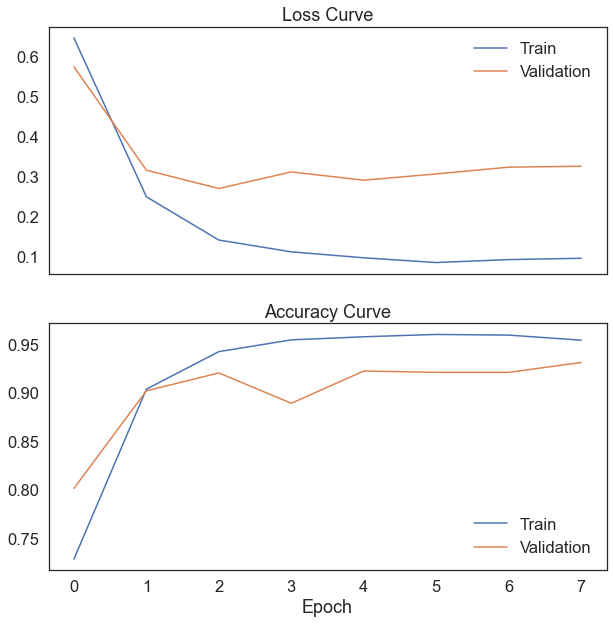

In [290]:
plt.style.use('seaborn-whitegrid')
sns.set(style="white", font_scale = 1.5)
fig, axes = plt.subplots(2,1, figsize=(10,10), sharex=True)
axes[0].set_title('Loss Curve')
axes[0].plot(history["Train Loss"], label='Train', )
axes[0].plot(history["Validation Loss"], label='Validation')
axes[0].legend()
#plot accuracy during training
axes[1].set_title('Accuracy Curve')
axes[1].plot(history["Train Accuracy"], label='Train')
axes[1].plot(history['Validation Accuracy'], label='Validation')
axes[1].legend()
axes[1].set_xlabel("Epoch")
plt.savefig("graph/Training Process Loss vs Accuracy.png")
plt.show()

In [ ]:
{"train loss": [0.6469, 0.2498, 0.1416,0.1122,0.0973,0.0854,0.0928,0.0961]}

In [134]:
# load a saved model
from keras.models import load_model
saved_model = load_model('model.01-0.64.h5')

Test Loss: 0.348009
Test Accuracy: 92.568713%


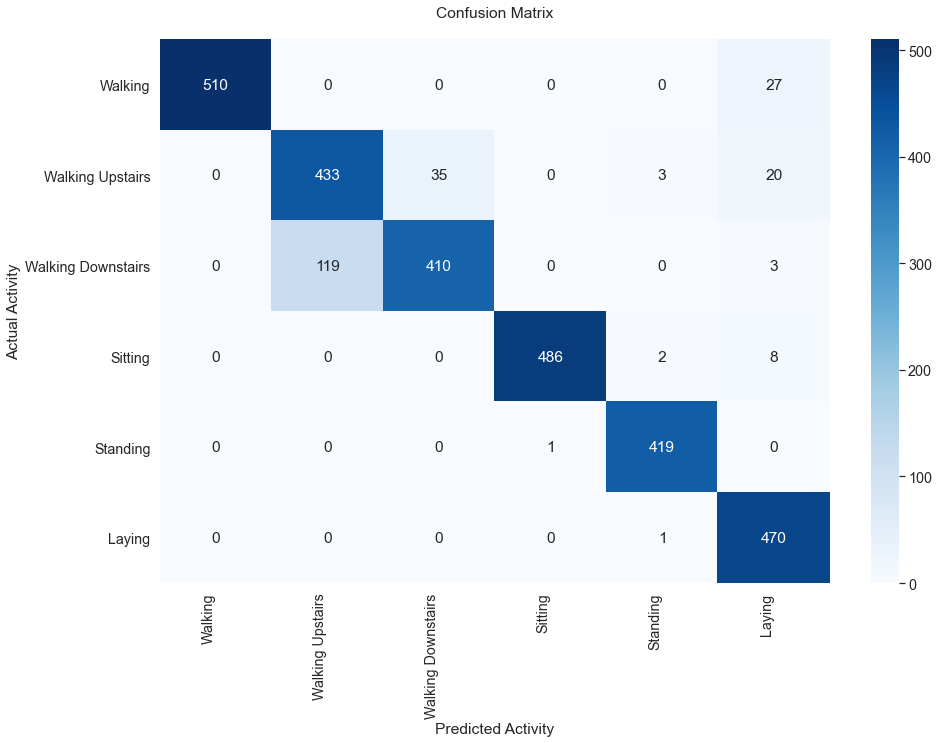

In [229]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Test Loss: %f" % (scores[0]))
print("Test Accuracy: %f%%" % (scores[1]*100))

# Confusion Matrix
y_predict=pd.Series([activities[i+1] for i in np.argmax(y_pred, axis=1)])
y_actual=pd.Series([activities[i+1] for i in np.argmax(y_test, axis=1)])


# Code for drawing seaborn heatmaps
class_names = list(activities.values())
df_heatmap = pd.DataFrame(confusion_matrix(y_actual, y_predict) )

plt.style.use('seaborn-whitegrid')
sns.set(style="white", font_scale = 1.3)

fig = plt.figure(figsize=(15,10))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d", cmap="Blues")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=90, ha='right')
heatmap.set_xticklabels(class_names)
heatmap.set_yticklabels(class_names)
plt.ylabel('Actual Activity')
plt.xlabel('Predicted Activity')
plt.title("Confusion Matrix\n")
plt.savefig("graph/Confusion Matrix.png")
plt.show()

In [174]:
#saving model
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [171]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")


Loaded model from disk


In [173]:
loaded_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
loaded_model.evaluate(X_test, y_test, verbose=1)

93/93 [==============================] - 0s 4ms/step - loss: 0.3480 - accuracy: 0.9257


[0.34800925850868225, 0.9256871342658997]

In [258]:
loaded_model.evaluate(X_train, y_train, verbose=1)

230/230 [==============================] - 1s 3ms/step - loss: 0.1303 - accuracy: 0.9551


[0.13030478358268738, 0.9551142454147339]

In [245]:
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, None, 30, 64)      1792      
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 15, 64)      0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 13, 128)     24704     
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 6, 128)      0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, None, 4, 256)      98560     
_________________________________________________________________
time_distributed_5 (TimeDist (None, None, 2, 256)      0         
_________________________________________________________________
dropout (Dropout)            (None, None, 2, 256)      0

#### Performance Table

In [353]:
perf=pd.DataFrame([["{0:0.2f}%".format(100*precision_score(y_actual, y_predict, average="micro")), 
                    "{0:0.2f}%".format(100*recall_score(y_actual, y_predict, average="micro")),
                    "{0:0.2f}%".format(100*f1_score(y_actual, y_predict, average="micro"))],
                  ["{0:0.2f}%".format(100*precision_score(y_actual, y_predict, average="macro")), 
                    "{0:0.2f}%".format(100*recall_score(y_actual, y_predict, average="macro")),
                    "{0:0.2f}%".format(100*f1_score(y_actual, y_predict, average="macro"))]], 
                  index=["Micro Average", "Macro Average"], columns=["Precision", "Recall", "F1-Score"])

In [354]:
perf

,Precision,Recall,F1-Score
Micro Average,92.57%,92.57%,92.57%
Macro Average,93.00%,92.96%,92.75%


In [356]:
print("Accuracy: {0:0.2f}%".format(100*accuracy_score(y_actual, y_predict)))

Accuracy: 92.57%


In [355]:
print("Precision: {0:0.2f}%".format(100*precision_score(y_actual, y_predict, average="micro")))
print("Recall: {0:0.2f}%".format(100*recall_score(y_actual, y_predict, average="micro")))
print("f1_score: {0:0.2f}%".format(100*f1_score(y_actual, y_predict, average="micro")))

Precision: 92.57%
Recall: 92.57%
f1_score: 92.57%


In [349]:
print("Precision: {0:0.2f}%".format(100*precision_score(y_actual, y_predict, average="macro")))
print("Recall: {0:0.2f}%".format(100*recall_score(y_actual, y_predict, average="macro")))
print("f1_score: {0:0.2f}%".format(100*f1_score(y_actual, y_predict, average="macro")))


Precision: 93.00%
Recall: 92.96%
f1_score: 92.75%



fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
#Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

#### ROC Curve

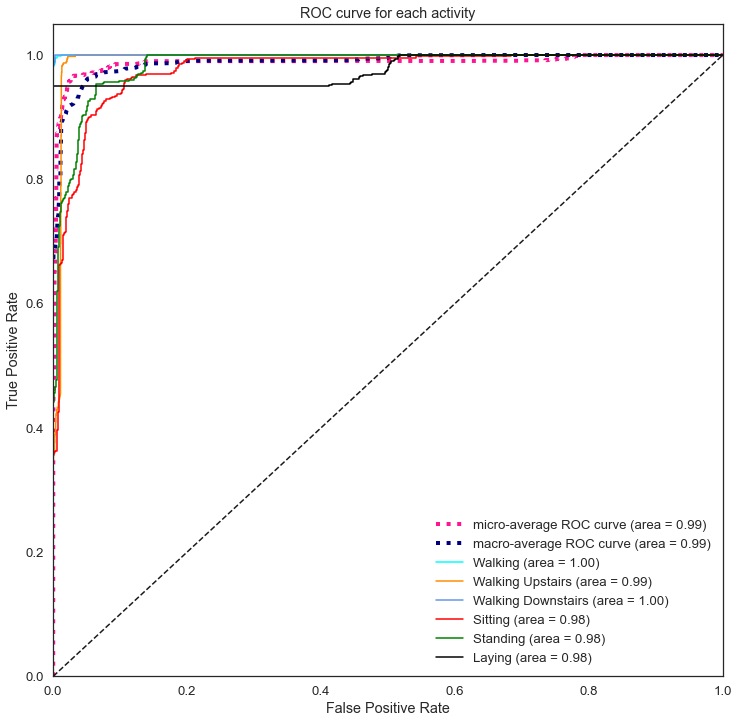

In [337]:
n_classes = 6
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.style.use('seaborn-whitegrid')
sns.set(style="white", font_scale = 1.2)
plt.figure(figsize=(12,12))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', "red", "green", "black"])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='{0} (area = {1:0.2f})'
             ''.format(activities[i+1], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for each activity')
plt.legend(loc="lower right")
plt.savefig("graph/ROC.png")
plt.show()